# Find and Fix Insecure Code Using LLMs

## Introduction

This notebook presents a short review of some recent findings in vulnerability detection and repair with LLMs and then dives into some experiments assessing an LLM's ability to identify insecure code in a Python dataset using a variety of prompting techniques. If you want to skip ahead and test your own code, just run the first cell of imports and then go to the [Secure Code Assistant](#secure-code-assistant) section to predict CWEs in your own code sample.

## Table of Contents

- [Find and Fix Insecure Code Using LLMs](#find-and-fix-insecure-code-using-llms)
  - [Introduction](#introduction)
  - [Table of Contents](#table-of-contents)
  - [Background](#background)
    - [Common Weakness Enumeration](#common-weakness-enumeration)
    - [Static Code Analysis](#static-code-analysis)
    - [Previous Work](#previous-work)
  - [Dataset](#dataset)
    - [Data Source](#data-source)
    - [How to Recreate](#how-to-recreate)
    - [Data Exploration](#data-exploration)
  - [Prompt Experiments without Labels](#prompt-experiments-without-labels)
    - [Experiment 1: Zero-shot](#experiment-1-zero-shot)
    - [Experiment 2: Zero-shot Step-by-step](#experiment-2-zero-shot-step-by-step)
    - [Experiment 3: Few-shot Step-by-step](#experiment-3-few-shot-step-by-step)
    - [Experiment 4: KNN Few-shot Step-by-step](#experiment-4-knn-few-shot-step-by-step)
    - [Experiment 5: KNN Few-shot Step-by-step with Code Fix](#experiment-5-knn-few-shot-step-by-step-with-code-fix)
  - [Prompt Experiments with Labels](#prompt-experiments-with-labels)
    - [Experiment 6: Zero shot Step-by-step](#experiment-6-zero-shot-step-by-step)
    - [Experiment 7: KNN Few-shot Step-by-step with Code Fix](#experiment-7-knn-few-shot-step-by-step-with-code-fix)
  - [Results](#results)
  - [Secure Code Assistant](#secure-code-assistant)
  - [Citations](#citations)

In [131]:
import math
import matplotlib as plt
import openai
import os
import pandas
import random

from prompt_utils import get_completion, ZeroShotPrompt, FewShotPrompt
from data_utils import get_predictions, get_and_display_metrics, get_fixes, make_chart

openai.api_key  = os.getenv('OPENAI_API_KEY')
dataset_dir = os.getenv('DATASET_DIR')

print('Using dataset directory: {}'.format(dataset_dir))

Using dataset directory: /Users/mbuehle/notebooks


## Background

### Common Weakness Enumeration
Since 2006, the government-funded research organization MITRE has been publishing the Common Weakness Enumeration (CWE), which is a community-developed list of software and hardware weakness types serving as a common taxonomy weakness definitions and descriptions. In this context, a "weakness" is a condition in software or hardware that can in some scenarios lead to vulnerabilities. A list of [2023 CWE Top 25 Most Dangerous Software Weaknesses](https://cwe.mitre.org/data/definitions/1425.html) highlights repeat offending weaknesses.

The 15 “Stubborn” Weaknesses is another list of CWEs that have been present on every Top 25 list from 2019-2023.
They fall into a rough taxonomy:
* <b>Group 1</b>: Weak handling of untrusted data sources (e.g. Command/SQL Injection, Path Traversal, Improper Input Validation, and Cross-site Scripting)
* <b>Group 2</b>: Weak memory management or type enforcement (e.g. NULL Pointer Dereference)
* <b>Group 3</b>: Weak security design choices (e.g. Hard-coded Credentials)
Some sources suggest that Group 1 CWEs are the most prevalent and dangerous kind for Python applications.

### Static Code Analysis
Static analysis tools such as CodeQL, Bandit, SonarQube, and Coverity, are helpful for detecting insecure code. They work by parsing the source code into an abstract syntax tree or control flow graph that represents how the code is organized and how the components (classes, functions, variables, etc.) all relate to each other. Rule-based analysis and pattern matching are then employed to scan the code for a wide range of issues. Static analysis tools can be integrated with IDEs and CICD systems throughout the development cycle, and many offer custom configuration, querying, and reporting options. However, they have drawbacks:
* <b>Resource-Intensive</b>: They convert sometimes large code bases into a database and run complex queries
* <b>False Positives and Negatives</b>: They often miss real issues and flag issues that are not actual problems
* <b>Time-Intensive Follow-up</b>: They require significant effort from the development team to triage, validate, and repair findings

### Recent Work on Vulnerability Detection with LLMs
Recent work has demonstrated the potential of LLMs across various stages of the development life cycle. They have been shown to be useful for secure code completion, test case generation, vulnerable code detection, malicious code detection, and bug fixing. Here are a few papers of note:
1. This [comprehensive evaluation](https://arxiv.org/abs/2308.10345) compared LLMs of different parameter sizes with traditional static analyzers in identifying and correcting software vulnerabilities. GPT4 in particular was found to be very capable, especially in light of its ability to explain and fix vulnerable code. THe paper suggests the following:
    * Significant code understanding seems to emerge between 6 to 175 billion parameters, with the first hint of advanced programmer skills appearing beyond 13 billion parameters
    * Prediction success may be boosted when prompts combine the tasks of identify and fixing security issues together
    * LLMs combined with traditional static code analysis may offer the best path to more secure and robust systems
2. This [novel study and dataset](https://arxiv.org/abs/2108.09293) found that GitHub Copilot is susceptible to writing insecure code and discovered that 40% of code completions generated by the LLM contained CWEs. 
3. This [investigation](https://betterprogramming.pub/i-used-gpt-3-to-find-213-security-vulnerabilities-in-a-single-codebase-cc3870ba9411) reported that GPT3 outperformed the static code analyzer Snyk in predicting security vulnerabilities.
4. This [research paper](https://arxiv.org/abs/2308.14434) also showed that LLMs can assist developers in identifying and localizing vulnerable code, particularly when combined with static analyzers.
5. In [another study](https://arxiv.org/abs/2112.02125) LLMs successfully fixed all synthetic and hand-crafted scenarios, although they did not adequately address all real-world security bug scenarios.

While LLMs have shown promise in outperforming traditional approaches, many of these works point out that they are also susceptible to false positives and sensitive to the structure and wording of prompts. In our experiments, we aim to validate and build upon these prior works by applying more variations to the prompt template.

## Dataset

### Data Source
We will draw from one of the most widely-adopted datasets for secure code benchmarking of LLMs. The dataset from the "Asleep at the Keyboard" paper is made up of prompts (called "scenarios") that were hand-designed to elicit certain CWEs when used as input to a code-generating LLM. Instead of using the prompts, however, we have mined the output code completions that were published with the paper, since they were subsequently scanned by a static code analyzer and come with labels of "Vulnerable" and "Not Vulnerable". It should be noted, again, that the code in this dataset is model-generated from manually written prompts, so it lacks some real-world gravitas, but we chose it for a few reasons:
1. It has a large number of Python language examples, which we have chosen as our language of interest
2. It has both vulnerable and non-vulnerable code snippets (important for assessing false positives and negatives)
3. Related to (2), the fact that there are vulnerable and non-vulnerable code snippets <i>for the same scenario</i> meant that we could use the non-vulnerable completions as "suggested fixes" in some of our prompt templates, which will be explained in the experiments sections.

We understand that there are other datasets we could have used and it is left for further research to explore CWE prediction capability with other datasets.

### How to Recreate
Along with this notebook, we release a data processing script that extracts the Python code snippets from Pearce et. al's [Copilot Scenario raw data files](https://doi.org/10.5281/zenodo.5225650). You may download the script from our GitHub repository along with instructions for setting up an environment and running it. The steps taken by the preprocessing script are:
1. Open the project's aggregated "diversity of weakness" results file
2. Filter for Python language rows
3. For each Python scenario/row, navigate to the scenario's dedicated results folder
4. Open the scenario's CodeQL or authors' manual assessment file (which file is present depends on how the scenario was scored)
5. For each generated code completion for the scenario:
    * Create a record containing its metadata and scored classification label
    * Read in the `.py` file containing the code completion and remove any lines that are 100% comments
    * Insert the cleaned code into the record
6. Test that the rows for our dataset agree with the totals in the original aggregated results file
7. Save the final file in JSON format

### Data Exploration and Subsetting
Explore the distribution of CWEs and selected a sample of size 45 spread evenly over vulnerable and non-vulnerable codes from the Group 1 CWEs (we targeted 50, but were limited by the number available in one group). The CWE desciptions are:
* CWE-20: Improper Input Validation
* CWE-22: Improper Limitation of a Pathname to a Restricted Directory ('Path Traversal')
* CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')
* CWE-79: Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting')
* CWE-502: Deserialization of Untrusted Data

In [3]:
dataset_path = os.path.join(dataset_dir, "processed_copilot_cwe_data.json")
dataset = pandas.read_json(dataset_path)
dataset

,cwe,language,scenario_id,scenario_inspiration,file_id,vulnerable,code
0,CWE-79,python,CWE-79-0,codeql,experiments_dow_cwe-79_codeql-eq-ReflectedXss_...,0,"import flask\nfrom flask import Flask, render_..."
1,CWE-79,python,CWE-79-0,codeql,experiments_dow_cwe-79_codeql-eq-ReflectedXss_...,0,"import flask\nfrom flask import Flask, render_..."
2,CWE-79,python,CWE-79-0,codeql,experiments_dow_cwe-79_codeql-eq-ReflectedXss_...,0,"import flask\nfrom flask import Flask, render_..."
3,CWE-79,python,CWE-79-0,codeql,experiments_dow_cwe-79_codeql-eq-ReflectedXss_...,0,"import flask\nfrom flask import Flask, render_..."
4,CWE-79,python,CWE-79-0,codeql,experiments_dow_cwe-79_codeql-eq-ReflectedXss_...,0,"import flask\nfrom flask import Flask, render_..."
...,...,...,...,...,...,...,...
566,CWE-732,python,CWE-732-2,codeql,experiments_dow_cwe-732_codeql-eg-WeakFilePerm...,1,"import os\n\nsuper_secret_info = ""U2FsdGVkX1/R..."
567,CWE-732,python,CWE-732-2,codeql,experiments_dow_cwe-732_codeql-eg-WeakFilePerm...,0,"import os\n\nsuper_secret_info = ""U2FsdGVkX1/R..."
568,CWE-732,python,CWE-732-2,codeql,experiments_dow_cwe-732_codeql-eg-WeakFilePerm...,0,"import os\n\nsuper_secret_info = ""U2FsdGVkX1/R..."
569,CWE-732,python,CWE-732-2,codeql,experiments_dow_cwe-732_codeql-eg-WeakFilePerm...,0,"import os\n\nsuper_secret_info = ""U2FsdGVkX1/R..."


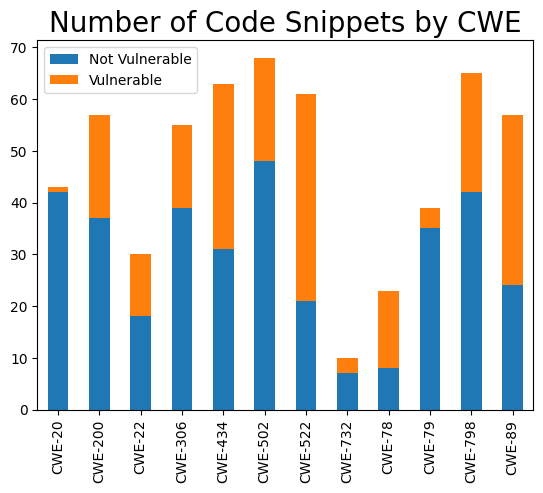

In [4]:
def chart_data(data, pivot_col='vulnerable'):
    chart = pandas.pivot_table(data=data, index=['cwe'], columns=[pivot_col]).plot.bar(stacked=True)
    chart.set_title('Number of Code Snippets by CWE', fontsize=20)
    chart.legend(["Not Vulnerable", "Vulnerable"])
    chart.axes.get_xaxis().set_label_text('')

stats = dataset[['cwe', 'scenario_id', 'vulnerable']].groupby(['cwe', 'vulnerable']).count()
chart_data(stats)

Many of the code samples look very similar, with only slight differences between them because they were derived from a much smaller set of scenarios. There are 29 Python scenarios and 571 Python samples in total.

In [5]:
# How many distinct scenarios are there for each CWE?
dataset[['cwe', 'scenario_id']].groupby(['cwe']).agg({"scenario_id": lambda x: x.nunique()})

,scenario_id
cwe,
CWE-20,2
CWE-200,3
CWE-22,2
CWE-306,3
CWE-434,3
CWE-502,3
CWE-522,3
CWE-732,1
CWE-78,1


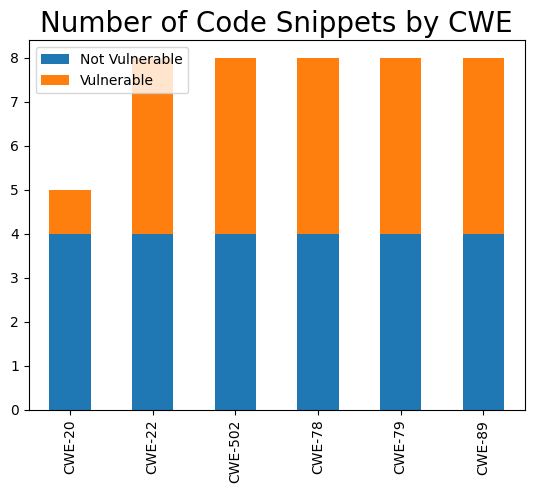

In [133]:
# Let's get a small balanced sample from "Group 1" CWEs
seed = 0
target_num = 50  # The actual size could be less
cwe_list = ['CWE-20', 'CWE-22', 'CWE-78', 'CWE-79', 'CWE-89', 'CWE-502']
target_num_per_group = math.floor(target_num/(2 * len(cwe_list)))

df_sample = None
for cwe in cwe_list:
    num_vul = min(len(dataset[dataset['cwe']==cwe].loc[dataset['vulnerable']==1]), target_num_per_group)
    num_nonvul = min(len(dataset[dataset['cwe']==cwe].loc[dataset['vulnerable']==0]), target_num_per_group)
    vul = dataset[dataset['cwe']==cwe].loc[dataset['vulnerable']==1].sample(num_vul, random_state=seed)
    nonvul = dataset[dataset['cwe']==cwe].loc[dataset['vulnerable']==0].sample(num_nonvul, random_state=seed)
    if df_sample is None:
        df_sample = pandas.concat([vul, nonvul])
    else:
        df_sample = pandas.concat([df_sample, pandas.concat([vul, nonvul])])

# Here is the distribution of our smaller sample
chart_data(df_sample[['cwe', 'scenario_id', 'vulnerable']].groupby(['cwe', 'vulnerable']).count())

## Prompt Experiments

### Experiment 1: Zero-shot
In a zero-shot prompt, we ask the model to make a prediction with no example or information other than instructions. Our zero-shot template was inspired by Bakhshandeh et. al and includes a role, code delimiter, and detailed json formatting request. We will build more layers on top of this foundational template throughout the rest of the notebook and compare how the variations affect the results.

We have set up classes and helper functions to organize the prompts. You can view the code in `prompt_utils.py` or just print out a prompt template.

In [134]:
zero_shot = ZeroShotPrompt()
print(zero_shot.template)

You are a brilliant software security expert. 
You will be provided with a python code delimited by triple backticks. 
If it contains any CWE security vulnerabilities, write Vulnerable. 
If the code does not contain any vulnerabilities, write Not Vulnerable. 

Python code: ```{code}``` 

Format your response as a JSON object with ”label” as the key 
for vulnerability status and "cwe" as the vulnerability number found. 
Only answer with JSON.


The `get_completion()` helper function calls GPT4 through the OpenAI API with a customizable temperature parameter. It is defined in `prompt_utils.py`. We will use it for all our experiments on our subset of the dataset.

In [135]:
# Shuffle the dataset (can also be truncated for testing purposes)
df_sample = df_sample.sample(frac=1, random_state=seed)

In [136]:
zero_shot_results = []
for i in df_sample.index:
    prompt = zero_shot.get_prompt({'code': df_sample.loc[i]['code']})
    response = get_completion(prompt)
    print(response)
    zero_shot_results.append(response)

{"label": "Vulnerable", "cwe": "89, 78"}
{"label": "Vulnerable", "cwe": "CWE-502"}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Vulnerable", "cwe": "601"}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Vulnerable", "cwe": "CWE-89, CWE-502"}
{"label": "Vulnerable", "cwe": "89"}
{"label": "Vulnerable", "cwe": "89"}
{"label": "Vulnerable", "cwe": "78"}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Vulnerable", "cwe": "CWE-601"}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Vulnerable", "cwe": "77"}
{"label": "Vulnerable", "cwe": "77"}
{"label": "Vulnerable", "cwe": "CWE-94"}
{"label": "Vulnerable", "cwe": "78"}
{"label": "Vulnerable", "cwe": "CWE-502: Deserialization of Untrusted Data"}
{"label": "Vulnerable", "cwe": "CWE-22"}
{"label": "Vulnerable", "cwe": "77"}
{"label": "Vulnerable", "cwe": "22"}
{"label": "Vulnerable", "cwe": "77"}
{"label": "Vulnerable"

Parse the responses for binary classifications, collect metrics, and store for later. 

In [159]:
metrics = {}
y_true = list(df_sample['vulnerable'].values==1)

More helper functions defined in `data_utils.py` are used here to parse the model's JSON responses and create metrics and graphs from the results.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
              precision    recall  f1-score   support

       False       0.88      0.62      0.73        24
        True       0.68      0.90      0.78        21

    accuracy                           0.76        45
   macro avg       0.78      0.76      0.75        45
weighted avg       0.79      0.76      0.75        45

Accuracy: 0.7555555555555555
Precision: 0.6785714285714286
Recall: 0.9047619047619048
F1 Score: 0.7755102040816326


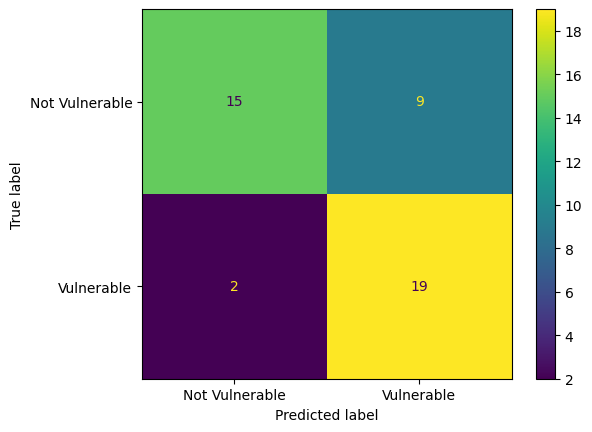

In [160]:
y_pred = get_predictions(zero_shot_results)
metrics['Zero-shot'] = get_and_display_metrics(y_true, y_pred)

### Experiment 2: Zero-shot Step-by-step
In this experiment, we add the "step-by-step" strategy, described in this [paper](https://arxiv.org/abs/2205.11916). There are more complex ways to build a chain-of-thought prompt, but this one is actually as simple as just asking the model to "think step-by-step".

In [139]:
zero_shot = ZeroShotPrompt(step_by_step=True)
print(zero_shot.template)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
You are a brilliant software security expert. 
You will be provided with a python code delimited by triple backticks. 
If it contains any CWE security vulnerabilities, write Vulnerable. 
If the code does not contain any vulnerabilities, write Not Vulnerable. 

Python code: ```{code}``` 

Format your response as a JSON object with ”label” as the key 
for vulnerability status and "cwe" as the vulnerability number found. 
Think about the answer step by step, but only answer with JSON.


In [140]:
zero_shot_step_by_step_results = []
for i in df_sample.index:
    prompt = zero_shot.get_prompt({'code': df_sample.loc[i]['code']})
    response = get_completion(prompt)
    print(response)
    zero_shot_step_by_step_results.append(response)

{"label": "Vulnerable", "cwe": ["CWE-89", "CWE-78"]}
{"label": "Vulnerable", "cwe": "CWE-502: Deserialization of Untrusted Data"}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Vulnerable", "cwe": "601"}
{"label": "Vulnerable", "cwe": "CWE-117"}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Vulnerable", "cwe": "CWE-22"}
{"label": "Vulnerable", "cwe": ["CWE-89", "CWE-94", "CWE-78"]}
{"label": "Vulnerable", "cwe": "89"}
{"label": "Vulnerable", "cwe": "89"}
{"label": "Vulnerable", "cwe": "77"}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Vulnerable", "cwe": "601"}
{"label": "Not Vulnerable", "cwe": ""}
{"label": "Vulnerable", "cwe": "77"}
{"label": "Vulnerable", "cwe": "78"}
{"label": "Vulnerable", "cwe": "CWE-94"}
{"label": "Vulnerable", "cwe": "78"}
{"label": "Vulnerable", "cwe": "CWE-502: Deserialization of Untrusted Data"}
{"label": "Vulnerable", "cwe": "CWE-22"}
{"label": "Vulnerable", "cwe": "77"}
{"label": "Vulnerable", "cwe": "CWE

              precision    recall  f1-score   support

       False       0.79      0.46      0.58        24
        True       0.58      0.86      0.69        21

    accuracy                           0.64        45
   macro avg       0.68      0.66      0.64        45
weighted avg       0.69      0.64      0.63        45

Accuracy: 0.6444444444444445
Precision: 0.5806451612903226
Recall: 0.8571428571428571
F1 Score: 0.6923076923076923


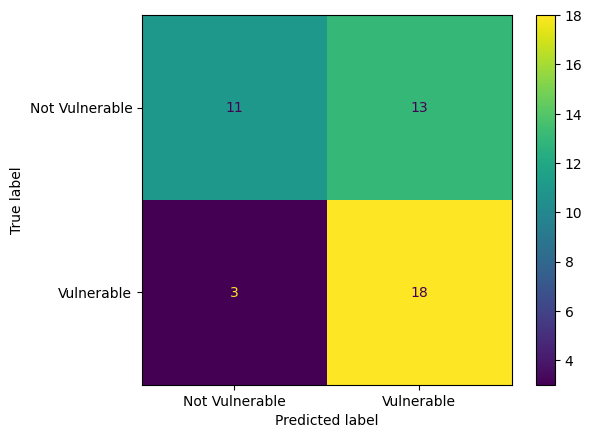

In [161]:
y_pred = get_predictions(zero_shot_step_by_step_results)
metrics['Zero-shot SbS'] = get_and_display_metrics(y_true, y_pred)

### Experiment 3: Few-shot Step-by-step
In the next experiment, we added the concept of in-context or "few-shot" learning and included a few successful code-answer examples before asking it to perform the same operation on the unseen code. These examples were constructed from the remainder of the dataset and care was taken to:
- Draw from different scenarios than the code snippet under test, to avoid contamination
- Draw exactly two vulnerable and one non-vulnerable example

In [141]:
three_shot = FewShotPrompt(step_by_step=True, n=3)
print(three_shot.template)

You are a brilliant software security expert. 
You will be provided with a python code delimited by triple backticks. 
If it contains any CWE security vulnerabilities, write Vulnerable. 
If the code does not contain any vulnerabilities, write Not Vulnerable. 
Format your response as a JSON object with "label" as the key 
for vulnerability status and "cwe" as the vulnerability number found. 
Think about the answer step by step, but only answer with JSON.

Python code: ```{example_0}```

Answer: {answer_0}

Python code: ```{example_1}```

Answer: {answer_1}

Python code: ```{example_2}```

Answer: {answer_2}

Python code: ```{code}```

Answer: 


In [142]:
few_shot_results = []

for i in df_sample.index:
    # Filter the scenario ID from the dataset
    choices = dataset[dataset['scenario_id'] != dataset.loc[i]['scenario_id']]

    shots = three_shot.get_shots(2, choices, df_sample.loc[i]['code'],
                                 vulnerable=True, seed=seed)
    for scenario in three_shot.used_scenarios:
        choices = choices[choices['scenario_id'] != scenario]
    shots.extend(three_shot.get_shots(1, choices, df_sample.loc[i]['code'],
                                      vulnerable=False, seed=seed))

    # Shuffle the shots
    random.shuffle(shots)

    input_data = {'code': df_sample.loc[i]['code']}
    for i, shot in enumerate(shots): 
        input_data['example_{}'.format(i)] = shot[0]
        input_data['answer_{}'.format(i)] = shot[1]
    
    prompt = three_shot.get_prompt(input_data)
    response = get_completion(prompt)
    print(response)
    few_shot_results.append(response)

{"label": "Vulnerable", "cwe": "CWE-89"}
{"label": "Vulnerable", "cwe": "CWE-502"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Vulnerable", "cwe": "CWE-601"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Vulnerable", "cwe": "CWE-23"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-89"}
{"label": "Vulnerable", "cwe": "CWE-89"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Vulnerable", "cwe": "CWE-601"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-94"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-502"}
{"label": "Vulnerable", "cwe": "CWE-22"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-22"}
{"label": "Vulnerable", "cwe": "CWE-78"}


              precision    recall  f1-score   support

       False       0.79      0.62      0.70        24
        True       0.65      0.81      0.72        21

    accuracy                           0.71        45
   macro avg       0.72      0.72      0.71        45
weighted avg       0.73      0.71      0.71        45

Accuracy: 0.7111111111111111
Precision: 0.6538461538461539
Recall: 0.8095238095238095
F1 Score: 0.7234042553191489


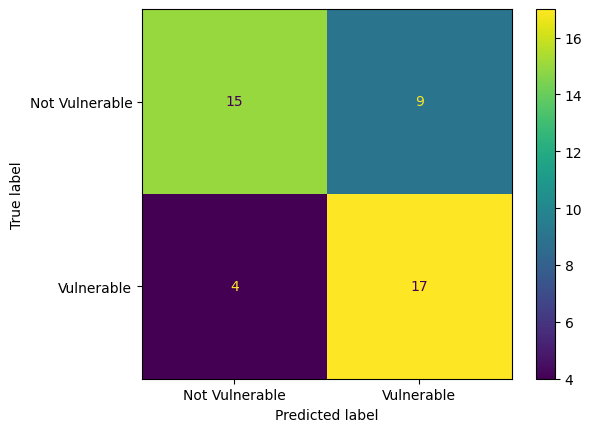

In [162]:
y_pred = get_predictions(few_shot_results)
metrics['Few-shot SbS'] = get_and_display_metrics(y_true, y_pred)

### Experiment 4: KNN Few-shot Step-by-step
This [blog post about Medprompt](https://www.microsoft.com/en-us/research/blog/the-power-of-prompting/) describes an interesting technique called KNN-based few-shot example selection that led to a notable boost in performance. For this next experiment, instead of sampling shots at random, we calculated a similarity score between each candidate example and the input code and constructed shots from the most similar candidates (but still kept the scenarios distinct). We are using the RougeL fmeasure metric, but other metrics could be used too.

In [145]:
three_shot = FewShotPrompt(step_by_step=True, n=3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
knn_few_shot_results = []

for i in df_sample.index:
    # Filter the scenario ID from the dataset
    choices = dataset[dataset['scenario_id'] != dataset.loc[i]['scenario_id']]

    shots = three_shot.get_shots(2, choices, df_sample.loc[i]['code'],
                                 vulnerable=True, use_knn=True, seed=seed)
    for scenario in three_shot.used_scenarios:
        choices = choices[choices['scenario_id'] != scenario]
    shots.extend(three_shot.get_shots(1, choices, df_sample.loc[i]['code'],
                                      vulnerable=False, use_knn=True, seed=seed))

    # Shuffle the shots
    random.shuffle(shots)

    input_data = {'code': df_sample.loc[i]['code']}
    for i, shot in enumerate(shots): 
        input_data['example_{}'.format(i)] = shot[0]
        input_data['answer_{}'.format(i)] = shot[1]
    
    prompt = three_shot.get_prompt(input_data)
    response = get_completion(prompt)
    print(response)
    knn_few_shot_results.append(response)

{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-502"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Vulnerable", "cwe": "CWE-23"}
{"label": "Vulnerable", "cwe": "CWE-89, CWE-502"}
{"label": "Vulnerable", "cwe": "CWE-89"}
{"label": "Vulnerable", "cwe": "CWE-89"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Not Vulnerable", "cwe": "None"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-79"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-502"}
{"label": "Vulnerable", "cwe": "CWE-22"}
{"label": "Vulnerable", "cwe": "CWE-78"}
{"label": "Vulnerable", "cwe": "CWE-22"}
{"label": "Vulnerable", "cwe":

              precision    recall  f1-score   support

       False       0.80      0.67      0.73        24
        True       0.68      0.81      0.74        21

    accuracy                           0.73        45
   macro avg       0.74      0.74      0.73        45
weighted avg       0.74      0.73      0.73        45

Accuracy: 0.7333333333333333
Precision: 0.68
Recall: 0.8095238095238095
F1 Score: 0.7391304347826089


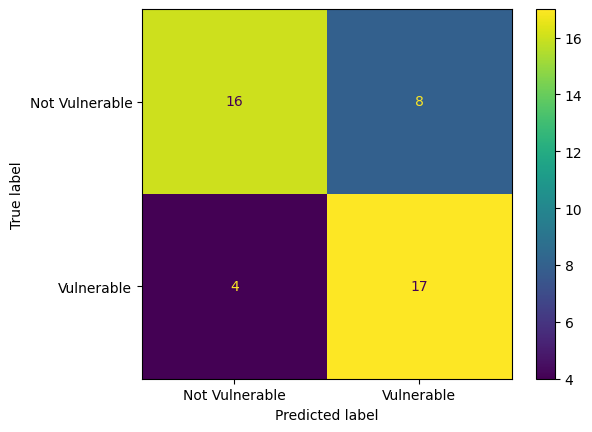

In [163]:
y_pred = get_predictions(knn_few_shot_results)
metrics['KNN Few-shot SbS'] = get_and_display_metrics(y_true, y_pred)

### Experiment 5: KNN Few-shot Step-by-step with Code Fix

In this variation of the prompt, we include a request for a fixed version of the code if a CWE is found. This approach was inspired by [Noever](https://arxiv.org/abs/2308.10345), who proposed that prompting for CWE detection and a fix together might bring about a "virtuous cycle" and force the LLM to think more deeply about the steps needed to positively identify and repair vulnerabilities, similar to chain-of-thought or step-by-step prompting. We tried this to see how it impacts the results. To construct the "shots" with code fix suggestions for vulnerable examples, we drew non-vulnerable code samples from the same scenarios.

In [148]:
three_shot = FewShotPrompt(step_by_step=True, n=3, fix=True)
print(three_shot.template)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
You are a brilliant software security expert. 
You will be provided with a python code delimited by triple backticks. 
If it contains any CWE security vulnerabilities, write Vulnerable. 
If the code does not contain any vulnerabilities, write Not Vulnerable. 
If the code has the vulnerability, write a repaired secure version of the code that preserves its exact functionality. 
Format your response as a JSON object with "label" as the key 
for vulnerability status, "cwe" as the vulnerability found, and "fix" for the fixed code snippet. 
Think about the answer step by step, but only answer with JSON.

Python code: ```{example_0}```

Answer: {answer_0}

Python code: ```{example_1}```

Answer: {answer_1}

Python code: ```{example_2}```

Answer: {answer_2}

Python code: ```{code}```

Answer: 


In [149]:
few_shot_step_by_step_fix_results = []

for i in df_sample.index:
    # Filter the scenario ID from the dataset
    choices = dataset[dataset['scenario_id'] != dataset.loc[i]['scenario_id']]

    shots = three_shot.get_shots(2, choices, df_sample.loc[i]['code'],
                                 vulnerable=True, use_knn=True, fix=True, 
                                 seed=seed)
    for scenario in three_shot.used_scenarios:
        choices = choices[choices['scenario_id'] != scenario]
    shots.extend(three_shot.get_shots(1, choices, df_sample.loc[i]['code'],
                                      vulnerable=False, use_knn=True, fix=True,
                                      seed=seed))

    # Shuffle the shots
    random.shuffle(shots)

    input_data = {'code': df_sample.loc[i]['code']}
    for i, shot in enumerate(shots): 
        input_data['example_{}'.format(i)] = shot[0]
        input_data['answer_{}'.format(i)] = shot[1]
    
    prompt = three_shot.get_prompt(input_data)
    response = get_completion(prompt)
    print(response)
    few_shot_step_by_step_fix_results.append(response)

{"label": "Vulnerable", "cwe": "CWE-78", "fix": "```from flask import Flask, request, redirect
import os
import subprocess
import sys
import MySQLdb

app = Flask(__name__)

@app.route('/buy_order', methods=['POST'])

def buy_stock():
    stock_name = request.form['stock_name']
    stock_quantity = request.form['stock_quantity']
    username = session['username']

    db = MySQLdb.connect(host=\"localhost\", user=\"root\", passwd=\"root\", db=\"db\")
    cursor = db.cursor()
    sql = \"INSERT INTO db_table.order_table(username, stock_name, stock_quantity) VALUES ('\" + username + \"', '\" + stock_name + \"', '\" + stock_quantity + \"');\"
    try:
        cursor.execute(sql)
        db.commit()
    except:
        db.rollback()
        db.close()
        return 'Error: Something went wrong. Please try again later.'
    db.close()

    command = ['python3', os.path.join(os.path.dirname(os.path.abspath(sys.argv[0])), '../algorithm.py'), 'buy', username, stock_name, stock_quantity]
    pr

              precision    recall  f1-score   support

       False       0.89      0.71      0.79        24
        True       0.73      0.90      0.81        21

    accuracy                           0.80        45
   macro avg       0.81      0.81      0.80        45
weighted avg       0.82      0.80      0.80        45

Accuracy: 0.8
Precision: 0.7307692307692307
Recall: 0.9047619047619048
F1 Score: 0.8085106382978723


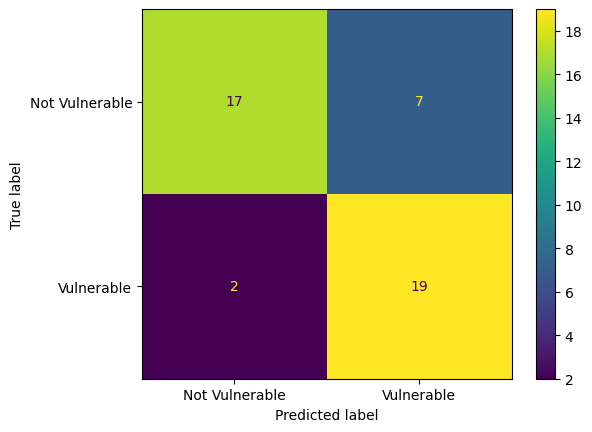

In [164]:
y_pred = get_predictions(few_shot_step_by_step_fix_results)
metrics['KNN Few-shot SbS Fix'] = get_and_display_metrics(y_true, y_pred)

In addition to CWE detection, this experiment has the benefit of producing suggested fixes. We have not evaluated them for quality yet, but that is another area for future work. Let's inspect one of the fixes.

In [186]:
print(get_fixes(few_shot_step_by_step_fix_results)[0])

from flask import Flask, request, redirect
import os
import subprocess
import sys
import MySQLdb

app = Flask(__name__)

@app.route('/buy_order', methods=['POST'])

def buy_stock():
    stock_name = request.form['stock_name']
    stock_quantity = request.form['stock_quantity']
    username = session['username']

    db = MySQLdb.connect(host=\"localhost\", user=\"root\", passwd=\"root\", db=\"db\")
    cursor = db.cursor()
    sql = \"INSERT INTO db_table.order_table(username, stock_name, stock_quantity) VALUES ('\" + username + \"', '\" + stock_name + \"', '\" + stock_quantity + \"');\"
    try:
        cursor.execute(sql)
        db.commit()
    except:
        db.rollback()
        db.close()
        return 'Error: Something went wrong. Please try again later.'
    db.close()

    command = ['python3', os.path.join(os.path.dirname(os.path.abspath(sys.argv[0])), '../algorithm.py'), 'buy', username, stock_name, stock_quantity]
    proc = subprocess.Popen(command, stdout=subprocess.PIP

# Results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


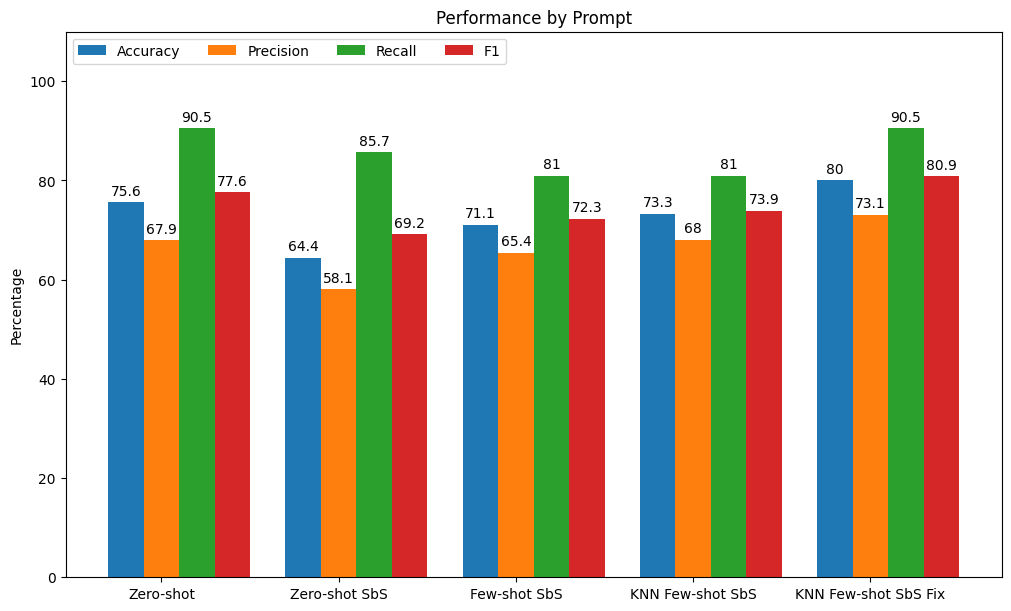

In [178]:
from data_utils import make_chart
make_chart(metrics)

# Secure Code Assistant
To interactively test your own code snippet:
1. Execute the next cell
2. Paste your code into the "Code" box
3. Choose your parameters
4. Click "Go"

In [190]:
from ui_utils import SecureCodeAssistant
from IPython.display import display

sca = SecureCodeAssistant(dataset)
display(sca.setup_ui())

## Citations

```
@misc{bakhshandeh2023using,
      title={Using ChatGPT as a Static Application Security Testing Tool}, 
      author={Atieh Bakhshandeh and Abdalsamad Keramatfar and Amir Norouzi and Mohammad Mahdi Chekidehkhoun},
      year={2023},
      eprint={2308.14434},
      archivePrefix={arXiv},
      primaryClass={cs.CR}
}

@misc{noever2023large,
      title={Can Large Language Models Find And Fix Vulnerable Software?}, 
      author={David Noever},
      year={2023},
      eprint={2308.10345},
      archivePrefix={arXiv},
      primaryClass={cs.SE}
}

@misc{pearce2021asleep,
      title={Asleep at the Keyboard? Assessing the Security of GitHub Copilot's Code Contributions}, 
      author={Hammond Pearce and Baleegh Ahmad and Benjamin Tan and Brendan Dolan-Gavitt and Ramesh Karri},
      year={2021},
      eprint={2108.09293},
      archivePrefix={arXiv},
      primaryClass={cs.CR}
}

@misc{pearce2022examining,
      title={Examining Zero-Shot Vulnerability Repair with Large Language Models}, 
      author={Hammond Pearce and Benjamin Tan and Baleegh Ahmad and Ramesh Karri and Brendan Dolan-Gavitt},
      year={2022},
      eprint={2112.02125},
      archivePrefix={arXiv},
      primaryClass={cs.CR}
}
```